In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np

def prepare_dlkcat_df(results_dict):
    flat = []
    for config, records in results_dict.items():
        for rec in records:
            flat.append({
                "config": rec["config"],
                "fold": rec["fold"],
                "split": rec["split"],
                "r2": rec["r2"],
            })
    return pd.DataFrame(flat)

def prepare_eitlem_df(results_all):
    flat = []
    for config, splits in results_all.items():
        for rec in splits.get("fixed", []):
            flat.append({
                "config": rec["config"],
                "split": "fixed",
                "r2": rec["r2"]
            })
        for split_mode in ["kfold", "groupkfold"]:
            for rec in splits.get(split_mode, []):
                flat.append({
                    "config": rec["config"],
                    "split": rec["split"],
                    "fold": rec.get("fold", -1),
                    "r2": rec["r2"]
                })
    return pd.DataFrame(flat)

def plot_r2_comparison(dlkcat_results_dict, eitlem_results_dict, output_path):
    # Prepare both DataFrames
    df_dlkcat = prepare_dlkcat_df(dlkcat_results_dict)
    df_eitlem = prepare_eitlem_df(eitlem_results_dict)

    dlkcat_configs = ["KinForm-H", "KinForm-L", "KinForm-L(OS)","UniKP"]
    eitlem_configs = ["KinForm-H", "KinForm-L", "KinForm-L(OS)","UniKP"]

    df_dlkcat["config"] = pd.Categorical(df_dlkcat["config"], categories=dlkcat_configs, ordered=True)
    df_eitlem["config"] = pd.Categorical(df_eitlem["config"], categories=eitlem_configs, ordered=True)

    main_colors_dlkcat = ['#2E86AB', '#A23B72', '#F18F01', '#50C878', '#9966CC'][:len(dlkcat_configs)]
    main_palette_dlkcat = dict(zip(dlkcat_configs, main_colors_dlkcat))
    main_colors_eitlem = ['#2E86AB', '#A23B72', '#F18F01', '#50C878']
    main_palette_eitlem = dict(zip(eitlem_configs, main_colors_eitlem))

    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'axes.linewidth': 1.2,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.8,
        'figure.facecolor': 'white'
    })

    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.22, wspace=0.01)

    # 1) Create DLKcat top and bottom
    ax_dlk_top = fig.add_subplot(gs[0, 0])
    ax_dlk_bot = fig.add_subplot(gs[1, 0], sharex=ax_dlk_top)

    # 1) Create EITLEM top sharing y‐axis with DLKcat top
    ax_eit_top = fig.add_subplot(gs[0, 1], sharey=ax_dlk_top)

    #    Create EITLEM bottom sharing y‐axis with DLKcat bottom
    ax_eit_bot = fig.add_subplot(gs[1, 1], sharey=ax_dlk_bot)

    # ------------------------------------------------------------
    # DLKcat: top = kfold, bottom = groupkfold
    for ax, ylim, split_df, is_group in zip(
        [ax_dlk_top, ax_dlk_bot],
        [(0.62, 0.73), (0.46, 0.552)],
        [df_dlkcat[df_dlkcat["split"] == "kfold"], df_dlkcat[df_dlkcat["split"] == "groupkfold"]],
        [False, True],
    ):
        # 3) If it’s the top (is_group == False), use a lower alpha to make boxes/lines more transparent
        alpha_box = 0.7 if not is_group else 1
        alpha_strip = 0.7 if not is_group else 1
        linestyle = '-' if is_group else '--'

        sns.boxplot(
            x="config", y="r2", data=split_df, ax=ax,
            palette=main_palette_dlkcat, width=0.6, showfliers=False,
            boxprops=dict(alpha=alpha_box, linewidth=1.5, linestyle=linestyle),
            medianprops=dict(color='#4B352A', linewidth=1, alpha=alpha_box),
            whiskerprops=dict(linewidth=1.5, linestyle=linestyle, alpha=alpha_box),
            capprops=dict(linewidth=1.5, linestyle=linestyle, alpha=alpha_box),
        )
        sns.stripplot(
            x="config", y="r2", data=split_df, ax=ax,
            palette=main_palette_dlkcat,
            size=5, jitter=0.25, edgecolor='white', linewidth=0.8,
            alpha=alpha_strip
        )

        # 2) Apply the new y‐limits
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.65)
        ax.set_axisbelow(True)
        ax.tick_params(axis='x', labelsize=12 if ax == ax_dlk_bot else 0, pad=5)
        ax.tick_params(axis='y', labelsize=11)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Broken y-axis marks (left side only)
    d = .015
    kwargs_top = dict(transform=ax_dlk_top.transAxes, color='k', clip_on=False)
    kwargs_bot = dict(transform=ax_dlk_bot.transAxes, color='k', clip_on=False)

    # Top left
    ax_dlk_top.plot((-d, +d), (-d, +d), **kwargs_top)
    # Bottom left
    ax_dlk_bot.plot((-d, +d), (1 - d, 1 + d), **kwargs_bot)


    # EITLEM: top = kfold, bottom = groupkfold
    df_fixed = df_eitlem[df_eitlem["split"] == "fixed"]
    for ax, ylim, split_df, is_group in zip(
        [ax_eit_top, ax_eit_bot],
        # 2) Updated y‐limits for top and bottom
        [(0.62, 0.73), (0.46, 0.552)],
        [df_eitlem[df_eitlem["split"] == "kfold"], df_eitlem[df_eitlem["split"] == "groupkfold"]],
        [False, True],
    ):
        alpha_box = 0.7 if not is_group else 1
        alpha_strip = 0.7 if not is_group else 1
        linestyle = '-' if is_group else '--'
        
        sns.boxplot(
            x="config", y="r2", data=split_df, ax=ax,
            palette=main_palette_eitlem,
            width=0.6, showfliers=False,
            boxprops=dict(alpha=alpha_box, linewidth=1.5, linestyle=linestyle),
            medianprops=dict(color='#4B352A', linewidth=1, alpha=alpha_box),
            whiskerprops=dict(linewidth=1.5, linestyle=linestyle, alpha=alpha_box),
            capprops=dict(linewidth=1.5, linestyle=linestyle, alpha=alpha_box),
        )
        sns.stripplot(
            x="config", y="r2", data=split_df, ax=ax,
            palette=main_palette_eitlem, size=5, jitter=0.3,
            edgecolor='white', linewidth=0.8, alpha=alpha_strip
        )

        # 2) Apply the new y‐limits
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.65)
        ax.set_axisbelow(True)
        ax.tick_params(axis='x', labelsize=12 if ax == ax_eit_bot else 0, pad=5)
        ax.tick_params(axis='y', labelsize=11)
        ax.set_xlabel("")
        ax.set_ylabel("")
        if ax in [ax_eit_top, ax_eit_bot]:
            ax.tick_params(left=False, labelleft=False)
            ax.spines['left'].set_visible(False)

    # Fixed split diamonds on top axis
    for i, cfg in enumerate(eitlem_configs):
        val = df_fixed[df_fixed["config"] == cfg]["r2"].values
        if len(val):
            ax_eit_top.plot(i, val[0], marker='D', color=main_colors_eitlem[i],
                            markersize=8, markeredgecolor='white', markeredgewidth=2,
                            zorder=15, alpha=0.95)

    reference_lines = [
        (0.672, "EITLEM Baseline", '#954C2E'),
        (0.722, "EITLEM TL Iter 8", '#096B68')
    ]
    for y_val, label, color in reference_lines:
        ax_eit_top.axhline(y=y_val, linestyle=":", linewidth=2, color=color, alpha=0.8, zorder=5)
        ax_eit_top.text(
            x=len(eitlem_configs) - 0.5, y=y_val + 0.004,
            s=label, color=color, fontsize=9, fontweight='medium',
            ha="right", va="bottom",
            bbox=dict(facecolor='white', edgecolor=color, alpha=0.85, pad=2, boxstyle="round,pad=0.2")
        )
    ax_dlk_top.set_title("DLKcat", fontsize=13, fontweight='normal')
    ax_eit_top.set_title("EITLEM", fontsize=13, fontweight='normal')

    # Shared ylabel
    fig.text(0.06, 0.5, r"Test $\mathbf{R}^2$", va='center', rotation='vertical', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.04, 'Model', ha='center', fontsize=14, fontweight='bold')

    # Legend
    legend_elements = [
        Patch(edgecolor='gray', facecolor='none', label='CV', linewidth=1.5, linestyle='--', alpha=0.7),
        Patch(edgecolor='gray', facecolor='none', label='GBCV', linewidth=1.5, linestyle='-'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='gray',
               markeredgecolor='white', markeredgewidth=1.5, markersize=8, label='EITLEM Split')
    ]
    fig.legend(handles=legend_elements, loc='upper center', frameon=True, fontsize=12, framealpha=0.9,bbox_to_anchor=(0.5, 0.98), 
               ncol = 3)
    # Dynamically compute midpoint between DLKcat and EITLEM subplots
    fig.canvas.draw()  # needed to ensure correct positions
    bbox_left  = ax_dlk_top.get_position()
    bbox_right = ax_eit_top.get_position()

    # Midpoint between right edge of left and left edge of right
    divider_x = (bbox_left.x1 + bbox_right.x0) / 2

    fig.add_artist(plt.Line2D([divider_x, divider_x], [0.1, 0.9], transform=fig.transFigure,
                            color='gray', linewidth=0.5, linestyle='-', alpha=0.6))

    fig.suptitle('$\mathbf{R}^2$ Comparison Between KinForm and Baselines', fontsize=16, fontweight='bold', y=1.02)
    fig.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()


<>:214: SyntaxWarning: invalid escape sequence '\m'
<>:214: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_9926/4052358903.py:214: SyntaxWarning: invalid escape sequence '\m'
  fig.suptitle('$\mathbf{R}^2$ Comparison Between KinForm and Baselines', fontsize=16, fontweight='bold', y=1.02)


/tmp/ipykernel_9926/4052358903.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_9926/4052358903.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipykernel_9926/4052358903.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_9926/4052358903.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipykernel_9926/4052358903.py:140: FutureWarni

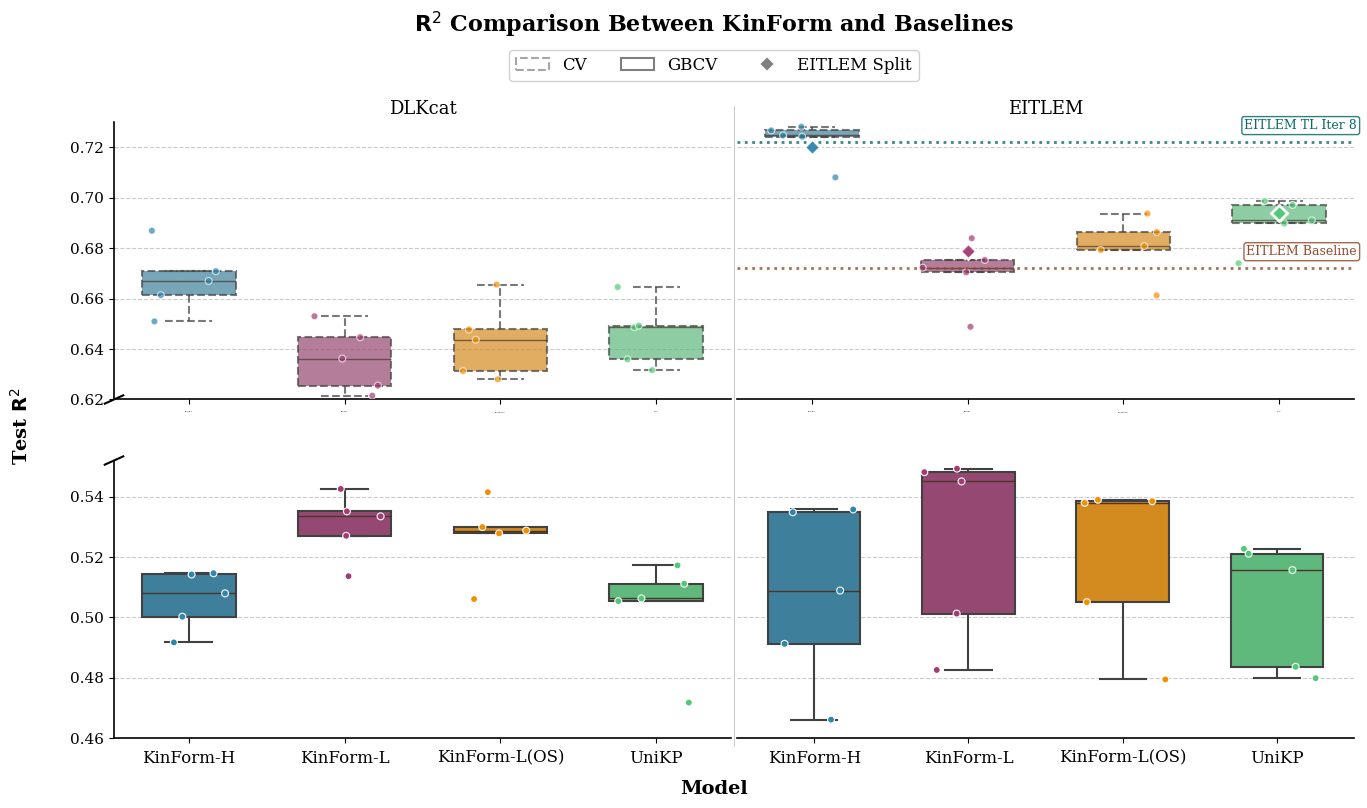

In [53]:
import pickle
import json
with open("/home/msp/saleh/KinForm/results/unikp_comp_eitlem.pkl", "rb") as f:
    results_eitlem = pickle.load(f)

results_dict_path = "/home/msp/saleh/KinForm/results/unikp_kineform_dlkcat_data.pkl"
with open(results_dict_path, "rb") as f:
    results_dlkcat = pickle.load(f)

# results_dlkcat = {k:v for k, v in results_dlkcat.items() if k != "KinForm-L"}
# results_dlkcat["KinForm-L"] = results_dlkcat.pop("KinForm-L(OS)")
# new_l = []
# for r in results_dlkcat["KinForm-L"]:
#     assert r["config"] == "KinForm-L(OS)"
#     r["config"] = "KinForm-L"
#     new_l.append(r)
# results_dlkcat["KinForm-L"] = new_l
# for split in ['kfold', 'groupkfold']:
#     results_eitlem["KinForm-L"][split] = [
#         {**r, 'config': 'KinForm-L'}
#         for r in results_eitlem["KinForm-L"][split]
#         if r['config'] == 'KinForm-L(OS)'
#     ]
plot_r2_comparison(
    dlkcat_results_dict=results_dlkcat,
    eitlem_results_dict=results_eitlem,
    output_path="/home/msp/saleh/KinForm/results/plots/r2_combined_dl_eitlem.png"
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

def plot_true_vs_pred(results_dict, output_path: str):
    # Collect all entries into flat df
    rows = []
    for config, records in results_dict.items():
        for rec in records:
            for y_t, y_p in zip(rec["y_true"], rec["y_pred"]):
                rows.append({
                    "config": rec["config"],
                    "split": rec["split"],
                    "y_true": y_t,
                    "y_pred": y_p
                })
    df_all = pd.DataFrame(rows)
    
    configs = ["KinForm-L", "KinForm-H", "UniKP"]
    splits = ["groupkfold", "kfold"]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True, constrained_layout=True)
    sns.set_theme(style="whitegrid", font_scale=1.3)

    for i, split in enumerate(splits):
        for j, config in enumerate(configs):
            ax = axes[i, j]
            df_plot = df_all[(df_all["config"] == config) & (df_all["split"] == split)]
            
            # Plot scatter
            sns.scatterplot(
                data=df_plot, x="y_true", y="y_pred", ax=ax,
                alpha=0.6, edgecolor="black", linewidth=0.4, s=40
            )
            # Identity line
            min_val, max_val = df_plot[["y_true", "y_pred"]].min().min(), df_plot[["y_true", "y_pred"]].max().max()
            ax.plot([min_val, max_val], [min_val, max_val], ls='--', color='gray', lw=1)

            # Pearson correlation
            pcc = pearsonr(df_plot["y_true"], df_plot["y_pred"])[0]
            ax.text(0.05, 0.92, f"PCC = {pcc:.3f}", transform=ax.transAxes,
                    fontsize=13, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray'))

            ax.set_title(f"{config} ({split})", fontsize=14)
            ax.set_xlabel("True log(kcat/Km)" if i == 1 else "")
            ax.set_ylabel("Predicted" if j == 0 else "")

    # --- Compute fold sizes per split ---
    fold_counts = {}
    for split in ["groupkfold", "kfold"]:
        fold_sizes = []
        for config in configs:  # get first config as reference
            fold_sizes = [
                len(r["y_true"])
                for r in results_dict[config]
                if r["split"] == split
            ]
            break  # use only the first config (folds are shared across configs)
        fold_counts[split] = fold_sizes

    # --- Build caption text ---
    caption_lines = []
    for split in ["groupkfold", "kfold"]:
        counts = fold_counts[split]
        caption_lines.append(f"{split}: n = [{', '.join(str(n) for n in counts)}]")

    caption_text = "\n".join(caption_lines)

    # Add text below figure
    fig.text(0.5, -0.02, caption_text, ha='center', va='center', fontsize=12)

    # Save & show
    fig.savefig(output_path, bbox_inches="tight", dpi=600)
    plt.show()

In [ ]:
plot_true_vs_pred(results_dict, "/home/msp/saleh/KinForm/results/plots/kcat_true_vs_pred_scatter.png")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import json
import math
from matplotlib.lines import Line2D

def plot_true_vs_pred_by_type(results_dict, raw_json_path, output_path):
    # Load and filter raw
    with open(raw_json_path, "r") as fp:
        raw = json.load(fp)
    raw = [d for d in raw if len(d["Sequence"]) <= 1499 and float(d["Value"]) > 0 and "." not in d["Smiles"]]
    types = [d["Type"] for d in raw]

    # Collect all points and total test counts
    rows = []
    split_test_idx_total = {"kfold": set(), "groupkfold": set()}

    for config, records in results_dict.items():
        if 'CW' in config:
            continue
        for rec in records:
            split = rec["split"]
            test_indices = rec["test_idx"]
            split_test_idx_total[split].update(test_indices)
            for idx, (y_t, y_p) in zip(test_indices, zip(rec["y_true"], rec["y_pred"])):
                rows.append({
                    "config": config,
                    "split": split,
                    "Type": types[idx],
                    "y_true": y_t,
                    "y_pred": y_p
                })
    df_all = pd.DataFrame(rows)

    # Setup plot grid
    sns.set_theme(style="whitegrid", font_scale=1.25)
    configs = ["KinForm-L", "KinForm-H", "UniKP"]
    split_colors = {"groupkfold": "#1f77b4", "kfold": "#ff7f0e"}

    fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True, sharey=True, constrained_layout=True)
    # Compute true total test counts per split
    split_counts = {k: len(v) for k, v in split_test_idx_total.items()}


    for i, config in enumerate(configs):
        for j, sample_type in enumerate(["wildtype", "mutant"]):
            ax = axes[i, j]
            for split, color in split_colors.items():
                df_plot = df_all[
                    (df_all["config"] == config) &
                    (df_all["split"] == split) &
                    (df_all["Type"] == sample_type)
                ]
                sns.scatterplot(
                    data=df_plot, x="y_true", y="y_pred", ax=ax,
                    label=split, color=color, s=40, alpha=0.6,
                    edgecolor="black", linewidth=0.4
                
                )
                # PCC
                if not df_plot.empty:
                    pcc = pearsonr(df_plot["y_true"], df_plot["y_pred"])[0]
                    ax.text(
                        0.05, 0.90 if split == "groupkfold" else 0.82,
                        f"{split} PCC = {pcc:.3f}",
                        transform=ax.transAxes, fontsize=11,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor=color)
                    )

            # Identity line
            min_val, max_val = df_all[["y_true", "y_pred"]].min().min(), df_all[["y_true", "y_pred"]].max().max()
            ax.plot([min_val, max_val], [min_val, max_val], ls='--', color='gray', lw=1)

            # Labels
            if i == 0:
                ax.set_title(f"{sample_type.capitalize()} Samples", fontsize=14)
            if j == 0:
                ax.set_ylabel(f"{config}\n\nPredicted log(kcat/Km)")
            else:
                ax.set_ylabel("")
            if i == 2:
                ax.set_xlabel("True log(kcat/Km)")
            else:
                ax.set_xlabel("")

    # remove default legend
    for ax in axes.flatten():
        ax.legend_.remove()
    # Add a single legend below all plots
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f"groupkfold (n = {split_counts['groupkfold']})",
               markerfacecolor=split_colors["groupkfold"], markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label=f"kfold (n = {split_counts['kfold']})",
               markerfacecolor=split_colors["kfold"], markersize=10, markeredgecolor='black'),
    ]
    fig.legend(
        handles=legend_elements, loc='lower center', ncol=2,
        bbox_to_anchor=(0.5, 1), frameon=False, fontsize=12
    )

    fig.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()


In [ ]:
plot_true_vs_pred_by_type(
    raw_json_path="/home/msp/saleh/KinForm/data/dlkcat_raw.json",
    results_dict=results_dict,
    output_path="/home/msp/saleh/KinForm/results/plots/kcat_true_vs_pred_scatter_by_type.png"
)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import json
from matplotlib.lines import Line2D

# Consistent styling
sns.set_theme(style="whitegrid", font_scale=1.3)
PCC_BOX_STYLE = dict(boxstyle="round,pad=0.3", facecolor='white')
SPLIT_LABELS = {"groupkfold": "5-fold GBCV", "kfold": "5-fold CV"}
SPLIT_COLORS = {"groupkfold": "#1f77b4", "kfold": "#ff7f0e"}
CONFIGS = ["KinForm-L", "KinForm-H", "UniKP"]
TYPES = ["wild", "mutant"]

def plot_true_vs_pred_all(results_dict, output_path: str):
    rows = []
    for config, splits in results_dict.items():
        for split_name in SPLIT_LABELS:
            for rec in splits.get(split_name, []):
                for y_t, y_p in zip(rec["y_true"], rec["y_pred"]):
                    rows.append({
                        "config": config,
                        "split": split_name,
                        "y_true": y_t,
                        "y_pred": y_p
                    })
    df_all = pd.DataFrame(rows)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True, constrained_layout=True)

    for j, config in enumerate(CONFIGS):
        ax = axes[j]
        for split, color in SPLIT_COLORS.items():
            df_plot = df_all[(df_all["config"] == config) & (df_all["split"] == split)]
            sns.scatterplot(
                data=df_plot, x="y_true", y="y_pred", ax=ax,
                label=SPLIT_LABELS[split], color=color, s=40, alpha=0.6,
                edgecolor="black", linewidth=0.4
            )
            if not df_plot.empty:
                pcc = pearsonr(df_plot["y_true"], df_plot["y_pred"])[0]
                pcc_text = f"{SPLIT_LABELS[split]} PCC = {pcc:.3f}   n = {len(df_plot)}"
                ax.text(
                    0.05, 0.9 if split == "groupkfold" else 0.82,
                    pcc_text,
                    transform=ax.transAxes, fontsize=12,
                    bbox=dict(**PCC_BOX_STYLE, edgecolor=color)
                )


        min_val, max_val = df_all[["y_true", "y_pred"]].min().min(), df_all[["y_true", "y_pred"]].max().max()
        ax.plot([min_val, max_val], [min_val, max_val], ls='--', color='gray', lw=1)
        ax.set_title(config, fontsize=14)
        ax.set_xlabel("True log(kcat)")
        if j == 0:
            ax.set_ylabel("Predicted log(kcat)")
        ax.legend_.remove()

    fig.savefig(output_path, bbox_inches="tight", dpi=600)
    plt.show()


def plot_true_vs_pred_by_type(results_dict, raw_json_path, output_path):
    with open(raw_json_path, "r") as fp:
        raw = json.load(fp)
    types = [d["type"] for d in raw if len(d["sequence"]) <= 1499 and float(d["value"]) > 0]

    rows = []
    for config, splits in results_dict.items():
        for split_name in SPLIT_LABELS:
            for rec in splits.get(split_name, []):
                for idx, (y_t, y_p) in zip(rec["test_indices"], zip(rec["y_true"], rec["y_pred"])):
                    rows.append({
                        "config": config,
                        "split": split_name,
                        "Type": types[idx],
                        "y_true": y_t,
                        "y_pred": y_p
                    })
    df_all = pd.DataFrame(rows)

    fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True, sharey=True, constrained_layout=True)

    for i, config in enumerate(CONFIGS):
        for j, typ in enumerate(TYPES):
            ax = axes[i, j]
            for split, color in SPLIT_COLORS.items():
                df_plot = df_all[
                    (df_all["config"] == config) &
                    (df_all["split"] == split) &
                    (df_all["Type"] == typ)
                ]
                sns.scatterplot(
                    data=df_plot, x="y_true", y="y_pred", ax=ax,
                    label=SPLIT_LABELS[split], color=color, s=40, alpha=0.6,
                    edgecolor="black", linewidth=0.4
                )
                if not df_plot.empty:
                    pcc = pearsonr(df_plot["y_true"], df_plot["y_pred"])[0]
                    pcc_text = f"{SPLIT_LABELS[split]} PCC = {pcc:.3f}   n = {len(df_plot)}"
                    ax.text(
                        0.05, 0.9 if split == "groupkfold" else 0.82,
                        pcc_text,
                        transform=ax.transAxes, fontsize=12,
                        bbox=dict(**PCC_BOX_STYLE, edgecolor=color)
                    )


            min_val, max_val = df_all[["y_true", "y_pred"]].min().min(), df_all[["y_true", "y_pred"]].max().max()
            ax.plot([min_val, max_val], [min_val, max_val], ls='--', color='gray', lw=1)

            if i == 0:
                type_text = "Wildtype" if typ == "wild" else "Mutant"
                ax.set_title(f"{type_text} Samples", fontsize=14)
            if j == 0:
                ax.set_ylabel(f"{config}\n\nPredicted log(kcat)")
            else:
                ax.set_ylabel("")
            if i == 2:
                ax.set_xlabel("True log(kcat)")
            else:
                ax.set_xlabel("")
            ax.legend_.remove()

    fig.savefig(output_path, dpi=600, bbox_inches="tight")
    plt.show()

plot_true_vs_pred_all(
    results_dict=results_all,
    output_path="/home/msp/saleh/KinForm/results/plots/scatter_cv_eitlemdata.png"
)

plot_true_vs_pred_by_type(
    results_dict=results_all,
    raw_json_path="/home/msp/saleh/KinForm/data/EITLEM_data/KCAT/kcat_data.json",
    output_path="/home/msp/saleh/KinForm/results/plots/scatter_cv_bytype_eitlemdata.png"
)


<>:398: SyntaxWarning: invalid escape sequence '\m'
<>:450: SyntaxWarning: invalid escape sequence '\m'
<>:398: SyntaxWarning: invalid escape sequence '\m'
<>:450: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_9926/1700239460.py:398: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("Test $\mathbf{R}^2$", fontsize=14, fontweight="bold", labelpad=10)
/tmp/ipykernel_9926/1700239460.py:450: SyntaxWarning: invalid escape sequence '\m'
  fig.suptitle("Test $\mathbf{R}^2$ Based on Sequence Similarity to Train Set", fontsize=18, fontweight="bold", y=1.1)


Loading cached mapping for DLKcat at 0.90 threshold
Loading cached mapping for DLKcat at 0.70 threshold
Loading cached mapping for DLKcat at 0.50 threshold
Loading cached mapping for DLKcat at 0.20 threshold
Loading cached mapping for EITLEM at 0.90 threshold
Loading cached mapping for EITLEM at 0.70 threshold
Loading cached mapping for EITLEM at 0.50 threshold
Loading cached mapping for EITLEM at 0.20 threshold


/tmp/ipykernel_9926/1700239460.py:327: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (cfg, bin_lab), g in df.groupby(["config", "sim_bin"]):
/tmp/ipykernel_9926/1700239460.py:327: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (cfg, bin_lab), g in df.groupby(["config", "sim_bin"]):
/tmp/ipykernel_9926/1700239460.py:327: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (cfg, bin_lab), g in df.groupby(["config", "s

✓ Saved /home/msp/saleh/KinForm/results/plots/r2_vs_similarity_combined.png


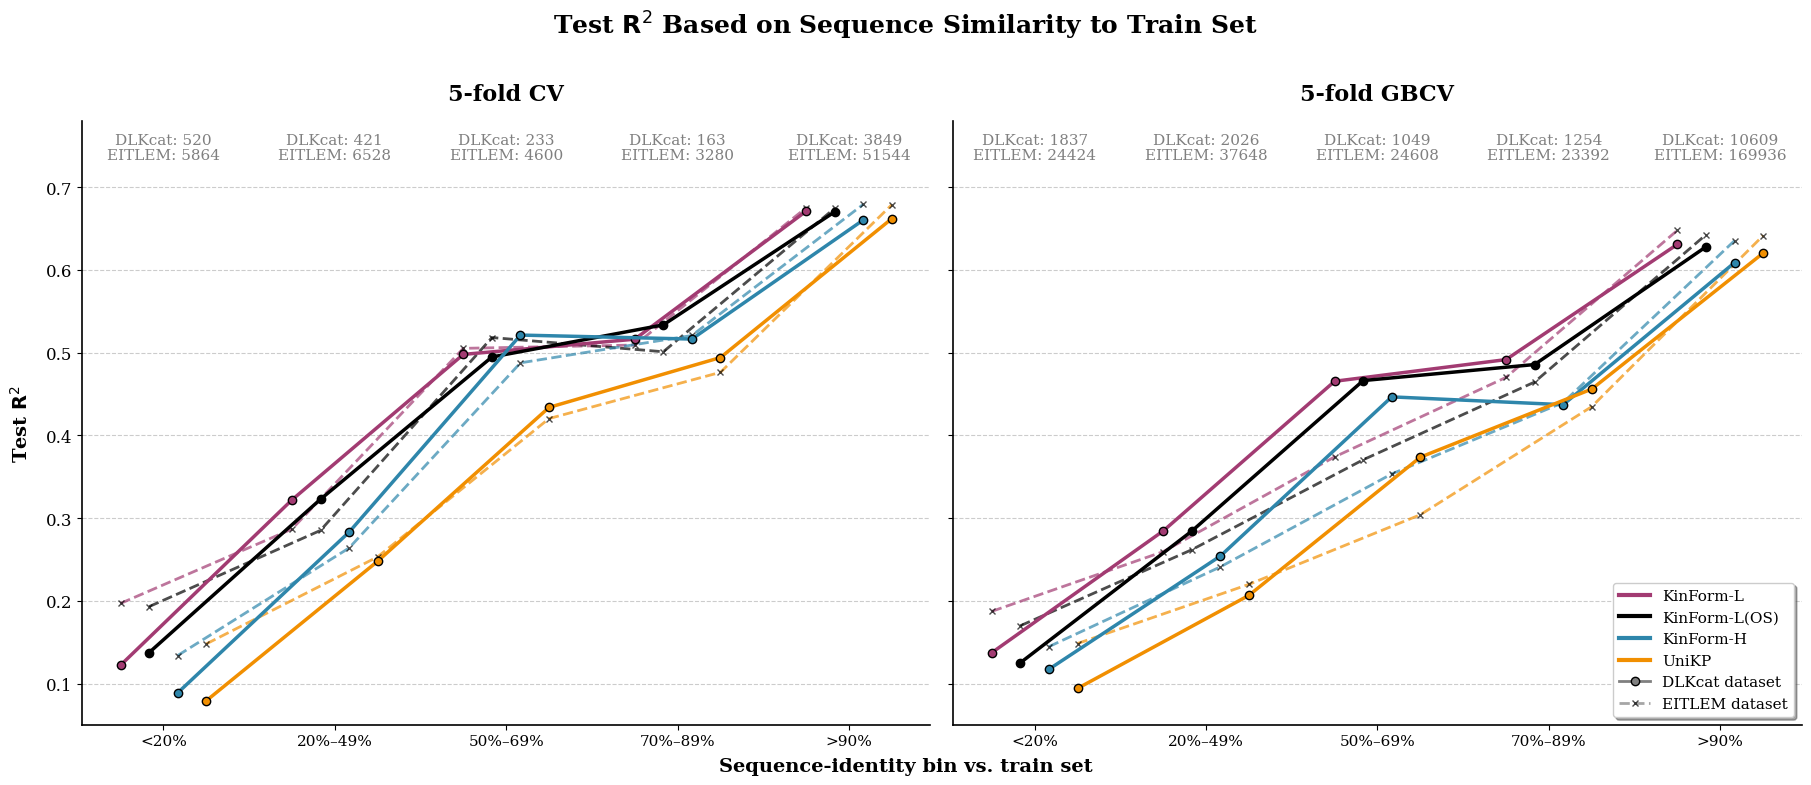

In [57]:
#!/usr/bin/env python3
"""
* Two panels:
    • left  – 5-fold CV   (standard KFold)
    • right – 5-fold GBCV (GroupKFold by protein ID)

* Either or both test-set datasets can be plotted.
  Set them with the --datasets CLI flag or by editing
  the `SELECTED_DATASETS` list below.

* Enhanced styling with cleaner visualization approach.
"""

from __future__ import annotations

import argparse
import json
import subprocess
import tempfile
from pathlib import Path
from typing import List, Dict, Any

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np

# ────────────────────────────── paths ─────────────────────────────── #
CONDA_EXE  = Path("/home/msp/miniconda3/bin/conda")
MMSEQS_ENV = "mmseqs"

DATA_FILES: Dict[str, Dict[str, Path]] = {
    "DLKcat": dict(
        raw=Path("/home/msp/saleh/KinForm/data/dlkcat_raw.json"),
        res=Path("/home/msp/saleh/KinForm/results/unikp_kineform_dlkcat_data.pkl"),
    ),
    "EITLEM": dict(
        raw=Path("/home/msp/saleh/KinForm/data/EITLEM_data/KCAT/kcat_data.json"),
        res=Path("/home/msp/saleh/KinForm/results/unikp_comp_eitlem.pkl"),
    ),
}

OUT_PNG = Path(
    "/home/msp/saleh/KinForm/results/plots/r2_vs_similarity_combined.png"
)

# ─────────────── similarity-band definition & order ──────────────── #
THR  = [0.9, 0.7, 0.5, 0.2]
LAB  = {
    0.9: ">90%",
    0.7: "70%–89%",
    0.5: "50%–69%",
    0.2: "20%–49%",
}
FALL = "<20%"
BINS = [FALL] + [LAB[t] for t in sorted(THR)]   # smallest → largest similarity

# ────────────────── model configs, colours, styles ────────────────── #
CONFIGS = ["KinForm-L","KinForm-L(OS)", "KinForm-H", "UniKP"]
# CONFIGS = ["KinForm-L(OS)"]


# Professional color palette matching previous plots
COLORS = {
    "KinForm-H": '#2E86AB',  # Professional blue
    "KinForm-L": '#A23B72',  # Professional purple  
    "KinForm-L(OS)": 'black',  # Black for OS variant
    "UniKP": '#F18F01'        # Professional orange
}

# Enhanced styling for datasets - using transparency and markers instead of line styles
DS_ALPHA = {"DLKcat": 1.0, "EITLEM": 0.7}
DS_MARKER = {"DLKcat": "o", "EITLEM": "x"}  # circle vs square
DS_SIZE = {"DLKcat": 6, "EITLEM": 5}
DS_LINESTYLE = {"DLKcat": "-", "EITLEM": "--"}
DS_HATCH   = {"DLKcat": "",   "EITLEM": "///"}

# ───────────────────────── MMseqs helpers ─────────────────────────── #
def mmseqs_cluster_map(seqs: List[str], min_id: float) -> Dict[int, int]:
    """Return {index → cluster_rep} mapping at given identity."""
    with tempfile.TemporaryDirectory() as td:
        td = Path(td)
        fa  = td / "seqs.fasta"
        pre = td / "clu"
        fa.write_text("".join(f">{i}\n{s}\n" for i, s in enumerate(seqs)))
        subprocess.run(
            [
                str(CONDA_EXE), "run", "-n", MMSEQS_ENV,
                "mmseqs", "easy-cluster",
                str(fa), str(pre), str(td),
                "--min-seq-id", str(min_id),
                "--cov-mode", "0", "-c", "0.8",
            ],
            check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL,
        )
        mapping: Dict[int, int] = {}
        with (pre.with_name(pre.name + "_cluster.tsv")).open() as f:
            for rep, mem in (map(int, l.split()) for l in f):
                mapping[mem] = mapping[rep] = rep
        for i in range(len(seqs)):          # singletons
            mapping.setdefault(i, i)
    return mapping

import pickle

CLUSTER_CACHE_DIR = Path("/home/msp/saleh/KinForm/results/cluster_cache")
CLUSTER_CACHE_DIR.mkdir(parents=True, exist_ok=True)

def build_maps(seqs: List[str], dataset_name: str) -> Dict[float, Dict[int, int]]:
    """Return {threshold → clustering_map} with disk caching."""
    cache_path = lambda thr: CLUSTER_CACHE_DIR / f"{dataset_name}_thr{int(thr*100):02d}.pkl"
    result = {}

    for thr in THR:
        path = cache_path(thr)
        if path.exists():
            print(f"Loading cached mapping for {dataset_name} at {thr:.2f} threshold")
            with open(path, "rb") as f:
                result[thr] = pickle.load(f)
        else:
            print(f"Building mapping for {dataset_name} at {thr:.2f} threshold")
            mapping = mmseqs_cluster_map(seqs, thr)
            with open(path, "wb") as f:
                pickle.dump(mapping, f)
            result[thr] = mapping

    return result

# ─────────────────────────── data loaders ─────────────────────────── #

def load_sequences(ds: str) -> List[str]:
    raw = json.loads(DATA_FILES[ds]["raw"].read_text())
    if ds == "DLKcat":
        return [
            d["Sequence"]
            for d in raw
            if len(d["Sequence"]) <= 1499 and float(d["Value"]) > 0 and "." not in d["Smiles"]
        ]
    # EITLEM schema
    return [d["sequence"] for d in raw if len(d["sequence"]) <= 1499 and float(d["value"]) > 0]

# ---------------------------------------------------------------------
# Fast helpers for folds / predictions – load once, return dicts
# ---------------------------------------------------------------------


def _get_folds(ds: str, mode: str, include_OS: bool = False) -> List[Dict[str, List[int]]]:
    """Returns [{train_indices, test_indices}, …] for the requested split."""
    res = pd.read_pickle(DATA_FILES[ds]["res"])
    folds: List[Dict[str, List[int]]] = []

    # DLKcat uses list‑style record; EITLEM uses dict‑style
    if ds == "DLKcat":
        if not include_OS:
            res = {k:v for k, v in res.items() if k != "KinForm-L"}
            res["KinForm-L"] = res.pop("KinForm-L(OS)")
            new_l = []
            for r in res["KinForm-L"]:
                assert r["config"] == "KinForm-L(OS)"
                r["config"] = "KinForm-L"
                new_l.append(r)
            res["KinForm-L"] = new_l
        fold_tmp: Dict[int, Dict[str, List[int]]] = {}
        for recs in res.values():
            for r in recs:
                if r["split"] != mode:
                    continue
                fld = fold_tmp.setdefault(r["fold"], {})
                fld.setdefault("train", r["train_idx"])
                fld.setdefault("test", r["test_idx"])
        folds = [
            {"train_indices": v["train"], "test_indices": v["test"]}
            for _, v in sorted(fold_tmp.items())
        ]
    else:  # EITLEM
        if not include_OS:
            for split in ['kfold', 'groupkfold']:
                res["KinForm-L"][split] = [
                    {**r, 'config': 'KinForm-L'}
                    for r in res["KinForm-L"][split]
                    if r['config'] == 'KinForm-L(OS)'
                ]
        for splits in res.values():
            if mode in splits:
                folds = [
                    {
                        "train_indices": f["train_indices"],
                        "test_indices": f["test_indices"],
                    }
                    for f in splits[mode]
                ]
                break
    return folds


def _load_preds(ds: str, mode: str, include_OS: bool = False) -> pd.DataFrame:
    """Return long‑form DataFrame with y_true / y_pred for requested split."""

    res = pd.read_pickle(DATA_FILES[ds]["res"])
    rows: List[Dict[str, Any]] = []

    if ds == "DLKcat":
        if not include_OS:
            res = {k:v for k, v in res.items() if k != "KinForm-L"}
            res["KinForm-L"] = res.pop("KinForm-L(OS)")
            new_l = []
            for r in res["KinForm-L"]:
                assert r["config"] == "KinForm-L(OS)"
                r["config"] = "KinForm-L"
                new_l.append(r)
            res["KinForm-L"] = new_l
        fold_test = {
            r["fold"]: r["test_idx"]
            for recs in res.values() for r in recs if r["split"] == mode
        }
        for cfg, recs in res.items():
            for r in recs:
                if r["split"] != mode:
                    continue
                idxs = r.get("test_idx", fold_test[r["fold"]])
                for i, (yt, yp) in zip(idxs, zip(r["y_true"], r["y_pred"])):
                    rows.append(
                        dict(dataset=ds, config=cfg, index=i, y_true=yt, y_pred=yp)
                    )
    else:  # EITLEM
        if not include_OS:
            for split in ['kfold', 'groupkfold']:
                res["KinForm-L"][split] = [
                    {**r, 'config': 'KinForm-L'}
                    for r in res["KinForm-L"][split]
                    if r['config'] == 'KinForm-L(OS)'
                ]
        for cfg, splits in res.items():
            for r in splits.get(mode, []):
                model = r.get("config", cfg)
                for i, (yt, yp) in zip(r["test_indices"], zip(r["y_true"], r["y_pred"])):
                    rows.append(
                        dict(dataset=ds, config=model, index=i, y_true=yt, y_pred=yp)
                    )

    df = pd.DataFrame(rows)
    return df

# ---------------------------------------------------------------------
# Fast similarity‑band assignment (vectorised)
# ---------------------------------------------------------------------

def _assign_bins_vectorised(
    test_idx: np.ndarray,
    train_idx: np.ndarray,
    rep_arrays: Dict[float, np.ndarray],
) -> list[str]:
    """Return list of similarity‑band labels for each test index (vectorised)."""
    # Build a boolean mask "is_in_train[thr]" for each threshold
    masks: Dict[float, np.ndarray] = {}
    for thr in THR:
        # membership check via numpy – treat sets as 1‑D array of reps in train set
        masks[thr] = np.isin(rep_arrays[thr][test_idx], rep_arrays[thr][train_idx])

    # initialise with FALL
    labels = np.full(test_idx.shape[0], FALL, dtype=object)

    # iterate thresholds **high → low**, assign first match
    for thr in THR:
        sel = masks[thr] & (labels == FALL)
        labels[sel] = LAB[thr]
    return labels.tolist()

# ---------------------------------------------------------------------
# Build R² summary tables (fast version)
# ---------------------------------------------------------------------

def build_r2_tables(
    datasets: list[str],
    seqs_cache: Dict[str, list[str]],
    maps_cache: Dict[str, Dict[float, Dict[int, int]]],
    mode: str,
    include_OS: bool = False, 
) -> tuple[pd.DataFrame, pd.DataFrame]:
    r2_rows: list[dict[str, Any]] = []
    count_frames: list[pd.Series] = []

    for ds in datasets:
        seqs = seqs_cache[ds]
        cmap = maps_cache[ds]
        folds = _get_folds(ds, mode, include_OS=include_OS)
        preds = _load_preds(ds, mode, include_OS=include_OS)

        # pre‑compute rep_arrays[thr] as numpy.array once per dataset
        rep_arrays = {
            thr: np.fromiter((cmap[thr][i] for i in range(len(seqs))), dtype=np.int32)
            for thr in THR
        }

        # build per‑fold similarity label DataFrame
        sim_rows: list[dict[str, Any]] = []
        for f_id, f in enumerate(folds):
            tr = np.array(f["train_indices"], dtype=np.int32)
            te = np.array(f["test_indices"], dtype=np.int32)

            # exclude identical sequences found in train set (fast set check)
            tr_seqs = {seqs[i] for i in tr}
            mask_valid = np.array([seqs[i] not in tr_seqs for i in te])
            te = te[mask_valid]
            if te.size == 0:
                continue

            labels = _assign_bins_vectorised(te, tr, rep_arrays)
            sim_rows.extend(
                dict(dataset=ds, index=int(i), sim_bin=lab) for i, lab in zip(te, labels)
            )

        df_sim = pd.DataFrame(sim_rows)
        df = preds.merge(df_sim, on=["dataset", "index"], how="inner")

        # ordered categoricals ensure consistent plotting / grouping
        df["sim_bin"] = pd.Categorical(df["sim_bin"], BINS, ordered=True)
        df["config"] = pd.Categorical(df["config"], CONFIGS, ordered=True)

        # counts for optional annotation
        count_frames.append(
            df_sim["sim_bin"].value_counts().reindex(BINS, fill_value=0).rename(ds)
        )

        # compute R² per (dataset, config, sim_bin)
        for (cfg, bin_lab), g in df.groupby(["config", "sim_bin"]):
            r2_val = r2_score(g.y_true, g.y_pred)
            r2_rows.append(
                dict(dataset=ds, config=cfg, sim_bin=bin_lab, r2=r2_val)
            )

    return pd.DataFrame(r2_rows), pd.concat(count_frames, axis=1)

# ---------------------------------------------------------------------
# Plotting
# ---------------------------------------------------------------------

def make_plot(datasets: list[str], include_OS: bool = False) -> None:

    # professional theme
    plt.rcParams.update(
        {
            "font.size": 12,
            "font.family": "serif",
            "axes.linewidth": 1.2,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.3,
            "grid.linewidth": 0.8,
            "figure.facecolor": "white",
        }
    )

    # cache sequences & cluster maps once
    seqs_cache = {ds: load_sequences(ds) for ds in datasets}
    maps_cache = {ds: build_maps(seqs_cache[ds], ds) for ds in datasets}

    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True, constrained_layout=True)
    titles = {"kfold": "5-fold CV", "groupkfold": "5-fold GBCV"}

    for ax, mode in zip(axes, ("kfold", "groupkfold")):
        df_r2, counts = build_r2_tables(datasets, seqs_cache, maps_cache, mode, include_OS=include_OS)
        df_r2["sim_bin"] = pd.Categorical(df_r2["sim_bin"], BINS, ordered=True)

        # x‑axis positions & offsets for models
        x_positions = np.arange(len(BINS))
        offset = np.linspace(-0.25, 0.25, num=len(CONFIGS))

        for cfg_i, cfg in enumerate(CONFIGS):
            for ds in datasets:
                line = (
                    df_r2.query("config == @cfg and dataset == @ds")
                    .sort_values("sim_bin")
                    .reset_index(drop=True)
                )
                if line.empty:
                    continue

                ax.plot(
                    x_positions + offset[cfg_i],
                    line["r2"],
                    color=COLORS[cfg],
                    alpha=DS_ALPHA[ds],
                    linestyle=DS_LINESTYLE[ds],
                    marker=DS_MARKER[ds],
                    markersize=DS_SIZE[ds],
                    linewidth=2.5 if ds == "DLKcat" else 2.0,
                    markeredgecolor="black",
                    markeredgewidth=1,
                    zorder=10 if ds == "DLKcat" else 5,
                )

        # axis formatting
        ax.set_title(titles[mode], fontsize=16, fontweight="bold", pad=15)

        if ax is axes[0]:
            ax.set_ylabel("Test $\mathbf{R}^2$", fontsize=14, fontweight="bold", labelpad=10)
        ax.set_ylim(0.05, 0.78)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(BINS, fontsize=11)
        ax.grid(axis="y", linestyle="--", linewidth=0.8, color="gray", alpha=0.4)
        ax.set_axisbelow(True)

        # subtle count annotations (optional)
        y_annot = 0.73
        for i, bin_name in enumerate(BINS):
            text_lines = [f"{ds}: {counts.loc[bin_name, ds]}" for ds in datasets]
            ax.text(
                i,
                y_annot,
                "\n".join(text_lines),
                ha="center",
                va="bottom",
                fontsize=11,
                color="gray",
                linespacing=1.1,
            )
    fig.supxlabel("Sequence‑identity bin vs. train set", fontsize=14, fontweight="bold", x =0.5)
    # legend
    legend_elements = [
        plt.Line2D([], [], color=COLORS[cfg], linewidth=3, label=cfg) for cfg in CONFIGS
    ]
    legend_elements += [
        plt.Line2D(
            [],
            [],
            color="gray",
            linestyle=DS_LINESTYLE[ds],
            marker=DS_MARKER[ds],
            markersize=DS_SIZE[ds],
            linewidth=2,
            alpha=DS_ALPHA[ds],
            label=f"{ds} dataset",
            markeredgecolor="black",
            markeredgewidth=1,
        )
        for ds in datasets
    ]
    axes[1].legend(
        handles=legend_elements,
        loc="lower right",
        frameon=True,
        fontsize=11,
        fancybox=True,
        shadow=True,
        columnspacing=1.5,
    )

    fig.suptitle("Test $\mathbf{R}^2$ Based on Sequence Similarity to Train Set", fontsize=18, fontweight="bold", y=1.1)
    plt.savefig(OUT_PNG, dpi=600, bbox_inches="tight", facecolor="white")
    print("✓ Saved", OUT_PNG)
    plt.show()


# ────────────────── choose which datasets to plot ─────────────────── #
SELECTED_DATASETS: List[str] = ["DLKcat", "EITLEM"]
# SELECTED_DATASETS: List[str] = ["DLKcat"]
# SELECTED_DATASETS: List[str] = ["EITLEM"]

make_plot(SELECTED_DATASETS, include_OS=True)

In [1]:
FIRST2_BINS = [FALL, LAB[THR[-1]]]
CONFIGS_OS = ["KinForm-L(OS)", "KinForm-L", "UniKP"]

COLORS = {
    "KinForm-L":     '#A23B72',   # purple (baseline)
    "KinForm-L(OS)": '#2E86AB',   # blue   (oversampled)
    "UniKP"     : '#F18F01',   # orange (UniKP)
}
DS_HATCH   = {"DLKcat": "",   "EITLEM": "///"}
DS_ALPHA   = {"DLKcat": 1.0,  "EITLEM": 0.8}
DS_MARKER  = {"DLKcat": "o",  "EITLEM": "x"}
DS_LINESTL = {"DLKcat": "-",  "EITLEM": "--"}

# --- Rewrite `build_r2_tables` to use reused vectorized version ---
def build_r2_tables(datasets, seqs_cache, maps_cache, mode):
    dfs = []
    for ds in datasets:
        seqs = seqs_cache[ds]
        cmap = maps_cache[ds]
        folds = _get_folds(ds, mode, include_OS=True)
        preds = _load_preds(ds, mode, include_OS=True)

        rep_arrays = {
            thr: np.fromiter((cmap[thr][i] for i in range(len(seqs))), dtype=np.int32)
            for thr in THR
        }

        sim_rows = []
        for f in folds:
            tr = np.array(f["train_indices"], dtype=np.int32)
            te = np.array(f["test_indices"], dtype=np.int32)
            tr_seqs = {seqs[i] for i in tr}
            mask = np.array([seqs[i] not in tr_seqs for i in te])
            te = te[mask]
            if te.size == 0:
                continue
            labs = _assign_bins_vectorised(te, tr, rep_arrays)
            sim_rows.extend(dict(dataset=ds, index=int(i), sim_bin=lab) for i, lab in zip(te, labs))

        df_sim = pd.DataFrame(sim_rows)
        df = preds.merge(df_sim, on=["dataset", "index"], how="inner")
        df = df[df.sim_bin.isin(FIRST2_BINS)]
        df = df[df["config"].isin(CONFIGS_OS)]

        df["sim_bin"] = pd.Categorical(df["sim_bin"], FIRST2_BINS, ordered=True)
        df["config"]  = pd.Categorical(df["config"], CONFIGS_OS, ordered=True)
        dfs.append(
            df.groupby(["dataset", "config", "sim_bin"])
              .apply(lambda g: r2_score(g.y_true, g.y_pred))
              .reset_index(name="r2")
        )
    return pd.concat(dfs, ignore_index=True)

def prepare_all(datasets: List[str]) -> Dict[str, pd.DataFrame]:
    """Call once – heavy MMseqs2 work & dataframe assembly."""
    seqs_cache = {ds: load_sequences(ds) for ds in datasets}
    maps_cache = {ds: build_maps(seqs_cache[ds], ds) for ds in datasets}

    # box-plot data (R², GBCV only)
    rows_box = []
    for ds in datasets:
        res = pd.read_pickle(DATA_FILES[ds]["res"])
        if ds == "DLKcat":                             # list style
            for cfg, recs in res.items():
                if cfg not in CONFIGS_OS:
                    continue
                rows_box.extend(
                    dict(dataset=ds, config=cfg,
                         r2=r["r2"], split=r["split"])
                    for r in recs if r["split"] == "groupkfold"
                )
        else:                                          # EITLEM dict
            for splits in res.values():               # only KinForm-L key
                rows_box.extend(
                    dict(dataset=ds, config=r["config"],
                         r2=r["r2"], split="groupkfold")
                    for r in splits["groupkfold"]
                    if r["config"] in CONFIGS_OS
                )
    df_box = pd.DataFrame(rows_box)
    df_box["config"] = pd.Categorical(df_box["config"], CONFIGS_OS, ordered=True)

    # R² vs similarity
    df_r2_k = build_r2_tables(datasets, seqs_cache, maps_cache, "kfold")
    df_r2_g = build_r2_tables(datasets, seqs_cache, maps_cache, "groupkfold")
    df_r2_k = df_r2_k[df_r2_k.sim_bin.isin(FIRST2_BINS)]
    df_r2_g = df_r2_g[df_r2_g.sim_bin.isin(FIRST2_BINS)]

    return dict(df_box=df_box, df_r2_k=df_r2_k, df_r2_g=df_r2_g)

NameError: name 'FALL' is not defined

In [ ]:
datasets = ["DLKcat", "EITLEM"]
dfs = prepare_all(datasets)     # heavy step – run once

In [ ]:
from matplotlib.patches import Patch, PathPatch
from matplotlib.gridspec import GridSpec
def plot_figure(dfs: Dict[str, pd.DataFrame], datasets: List[str]):
    df_box, df_r2_k, df_r2_g = dfs["df_box"], dfs["df_r2_k"], dfs["df_r2_g"]

    plt.rcParams.update({
        'font.size': 12, 'font.family': 'serif',
        'axes.linewidth': 1.2, 'axes.spines.top': False,
        'axes.spines.right': False, 'grid.alpha': .3,
    })

    fig = plt.figure(figsize=(8, 7), constrained_layout=True)
    gs  = GridSpec(2, 2, figure=fig,
                height_ratios=[1, 1],
                width_ratios =[1, 1],
                hspace=0.1, wspace=0.02)

    # (a) spans the full width in row 0
    axA = fig.add_subplot(gs[0, :])

    # (b) is bottom-left, (c) is bottom-right
    axB = fig.add_subplot(gs[1, 0])
    axC = fig.add_subplot(gs[1, 1], sharey=axB)

    patches = []
    spacing = 0.3
    box_w   = 0.2
    for i, cfg in enumerate(CONFIGS_OS):
        for j, ds in enumerate(datasets):
            vals = df_box.query("config == @cfg and dataset == @ds")["r2"].values
            if len(vals) == 0:
                continue
            pos = i * (len(datasets) + spacing) + j
            bp = axA.boxplot(
                [vals], positions=[pos], widths=box_w,
                patch_artist=True, showfliers=True,
                boxprops=dict(
                    facecolor=COLORS[cfg], 
                    hatch=DS_HATCH[ds],
                    edgecolor="black", linewidth=1.5
                ),
                medianprops=dict(color="black", linewidth=1.0),
                whiskerprops=dict(color="black", linewidth=1.0),
                capprops=dict(color="black", linewidth=1.0)
            )
            patches.append(bp["boxes"][0])

    n_ds       = len(datasets)    
    step       = n_ds + spacing        
    centers    = [i * step + (n_ds - 1) / 2 for i, _ in enumerate(CONFIGS_OS)]
    model_names = [] 
    for cfg in CONFIGS_OS:
        if cfg == "KinForm-L(OS)":
            model_names.append("KinForm-L")
        elif cfg == "KinForm-L":
            model_names.append("KinForm-L(NO OS)")
        else:
            model_names.append(cfg)              
    axA.set_xticks(centers)
    axA.set_xticklabels(model_names, fontsize=12)
    axA.set_ylabel("Test $\mathbf{R}^2$", fontweight="bold", fontsize=12)
    axA.set_xlabel("Model", fontweight="bold", fontsize=12)
    axA.set_ylim(0.465, 0.56)
    axA.set_title("(a) Overall Performance (GBCV folds)", fontsize=14, fontweight="bold", y=1)
    axA.grid(axis="y", linestyle="--", linewidth=0.8, color="gray", alpha=0.4)

    # Redefine bar_panel to accept any Axes; you just pass axB or axC
    def bar_panel(ax, df_r2, title):
        temp_f2 = [FIRST2_BINS[0]]
        x = np.arange(len(temp_f2))
        w = 0.18
        order = []
        for ds in datasets:
            for cfg in CONFIGS_OS:
                order.append((ds, cfg))

        for j, (ds, cfg) in enumerate(order):
            vals = [
                df_r2.query("dataset==@ds & config==@cfg & sim_bin==@b")["r2"].mean()
                for b in temp_f2
            ]
            ax.bar(
                x + (j - 1.5) * w,
                vals,
                width=w,
                facecolor=COLORS[cfg],
                edgecolor="black",
                hatch=DS_HATCH[ds],
                alpha=DS_ALPHA[ds]
            )

        group_center = np.mean([x[0] + (j - 1.5) * w for j in range(len(order))])
        ax.set_xticks([group_center])
        ax.set_xticklabels(["<20% identity"])
        ax.set_ylim(0.05, 0.22)
        ax.set_ylabel("Test $\mathbf{R}^2$", fontweight="bold")
        prefix = "(b)" if ax is axB else "(c)"
        ax.set_title(f"{prefix} {title}", fontweight="bold", fontsize=14)
        ax.set_axisbelow(True)
        ax.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.3)
        ax.grid(axis="y", ls="--", lw=0.8, c="gray", alpha=0.4)
        if ax is axC:
            # remove y-axis labels/ticks on panel (c)
            ax.set_ylabel("")
            ax.tick_params(labelleft=False)

    # Now call bar_panel on axB and axC:
    bar_panel(axB, df_r2_k, "5-fold CV")
    bar_panel(axC, df_r2_g, "5-fold GBCV")

    # Unified legend: draw it on axA (or wherever you like)
    legend_handles = [
        Patch(facecolor=COLORS["KinForm-L"],    edgecolor="black", label="KinForm-L(NO OS)"),
        Patch(facecolor=COLORS["KinForm-L(OS)"], edgecolor="black", label="KinForm-L"),
        Patch(facecolor=COLORS["UniKP"],        edgecolor="black", label="UniKP"),
        Patch(facecolor="white",                edgecolor="black", hatch="",    label="DLKcat"),
        Patch(facecolor="white",                edgecolor="black", hatch="///", label="EITLEM"),
    ]
    fig.legend(handles=legend_handles, fontsize=11,
                loc="upper center", frameon=True,
                ncols=5, bbox_to_anchor=(0.5, 1.07))

    fig.supxlabel("Sequence-identity band vs. train set",
                fontsize=12, fontweight="bold", x=0.5)
    fig.suptitle("Effect of Oversampling on Model Performance",
                fontsize=16, fontweight="bold", y=1.1)

    fig.savefig(OUT_PNG, dpi=600, bbox_inches="tight", facecolor="white")
    plt.show()
    print("✓ Saved", OUT_PNG)

In [ ]:
OUT_PNG = Path("/home/msp/saleh/KinForm/results/plots/OSvsNo_OS.png")
plot_figure(dfs, datasets) 

In [54]:
df

,ECNumber,Organism,Smiles,Mutation,kcat_real,kcat_pred,Model,enzyme_id
0,1.14.99.1,Ovis aries,OO,wildtype,17.0,27.530610,KinForm-L,1.14.99.1 | Ovis aries
1,1.14.99.1,Ovis aries,OO,wildtype,17.0,31.371903,UniKP,1.14.99.1 | Ovis aries
2,1.14.99.1,Ovis aries,OO,Q203N,11.0,185.290545,KinForm-L,1.14.99.1 | Ovis aries
3,1.14.99.1,Ovis aries,OO,Q203N,11.0,51.112665,UniKP,1.14.99.1 | Ovis aries
4,1.14.99.1,Ovis aries,OO,L294S,1200.0,190.183095,KinForm-L,1.14.99.1 | Ovis aries
...,...,...,...,...,...,...,...,...
175,3.1.3.12,Brugia malayi,C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O...,E386A,2.0,2.284511,UniKP,3.1.3.12 | Brugia malayi
176,3.1.3.12,Brugia malayi,C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O...,E384A,3.0,5.069532,KinForm-L,3.1.3.12 | Brugia malayi
177,3.1.3.12,Brugia malayi,C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O...,E384A,3.0,2.444637,UniKP,3.1.3.12 | Brugia malayi
178,3.1.3.12,Brugia malayi,C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O...,Y225A,6.0,4.623164,KinForm-L,3.1.3.12 | Brugia malayi


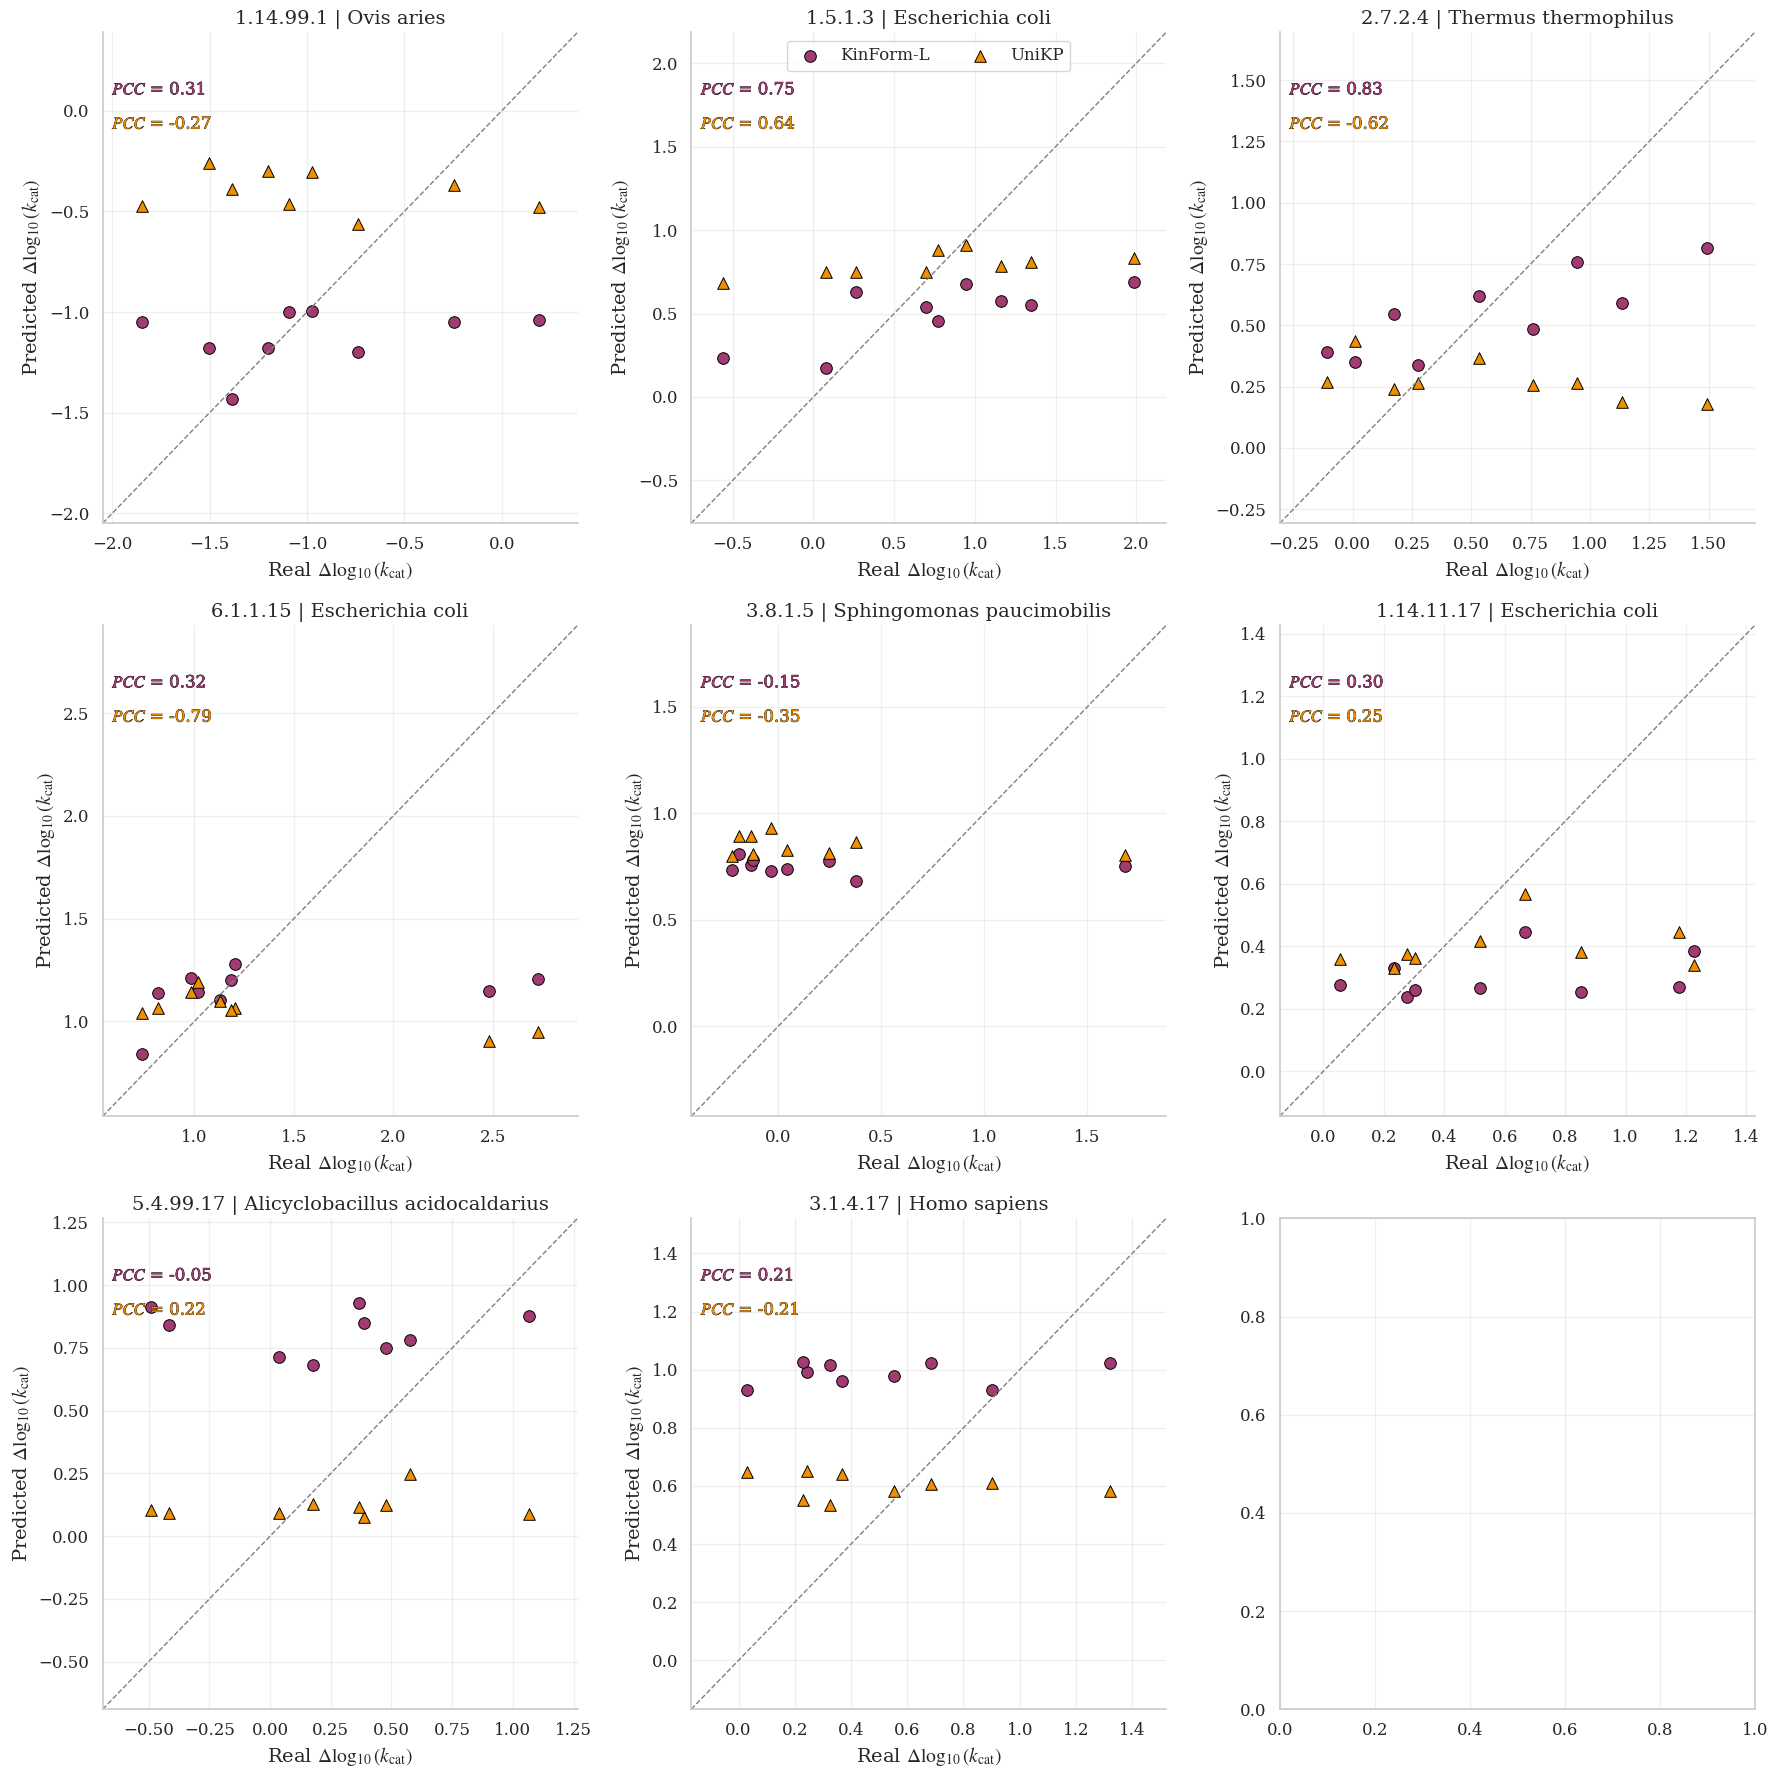

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error


# Load long-format results
df = pd.read_csv("/home/msp/saleh/KinForm/results/probe_enzyme_predictions_long.csv")

# Combine ECNumber and Organism into a single identifier
df["enzyme_id"] = df["ECNumber"].astype(str) + " | " + df["Organism"]

# Define model configurations: name, color, marker
MODEL_CONFIGS = [
    {"name": "KinForm-L", "color": "#A23B72", "marker": "o"},
    {"name": "UniKP",     "color": "#F18F01", "marker": "^"},
]
def build_delta_kcat_table(enz_df: pd.DataFrame) -> pd.DataFrame:
    enz_df = enz_df.copy()
    enz_df["real_log"] = np.log10(enz_df["kcat_real"])
    enz_df["pred_log"] = np.log10(enz_df["kcat_pred"])

    real_series = (
        enz_df[["Mutation", "real_log"]]
        .drop_duplicates()
        .set_index("Mutation")["real_log"]
    )
    # drop rows with 'Mutation' == 'wildtype' as they are not mutations
    enz_df = enz_df[enz_df["Mutation"] != "wildtype"].copy()
    preds = enz_df.pivot_table(index="Mutation", columns="Model", values="pred_log")
    
    table = pd.DataFrame(index=preds.index)
    table["real_log"] = real_series.reindex(table.index)

    wt_log = real_series.get("wildtype", np.nan)
    if pd.isna(wt_log):
        return None

    table["real_delta"] = wt_log - table["real_log"]

    for config in MODEL_CONFIGS:
        model = config["name"]
        if model in preds.columns:
            table[f"{model}_delta"] = wt_log - preds[model]

    return table

# Plot style
sns.set(style="whitegrid")
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "font.family": "serif",
    "mathtext.fontset": "stix",
})

unique_enzymes = df["enzyme_id"].unique()
n = len(unique_enzymes)
cols = 3
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), squeeze=False)

for idx, enzyme in enumerate(unique_enzymes):
    row, col = divmod(idx, cols)
    ax = axes[row, col]
    enz_df = df[df["enzyme_id"] == enzyme].copy()
    delta_table = build_delta_kcat_table(enz_df)

    if delta_table is None:
        continue

    y_max = -np.inf
    y_min = np.inf

    for config in MODEL_CONFIGS:
        model = config["name"]
        color = config["color"]
        marker = config["marker"]
        ycol = f"{model}_delta"

        if ycol in delta_table.columns:
            x = delta_table["real_delta"]
            y = delta_table[ycol]
            mask = ~(x.isna() | y.isna())
            x, y = x[mask], y[mask]

            # Scatter
            ax.scatter(x, y, label=model, color=color, marker=marker,
                       s=70, edgecolor="black", linewidth=0.7)

            # Update global y-limits
            y_max = max(y_max, y.max())
            y_min = min(y_min, y.min())

            # Pearson & RMSE
            pcc, _ = pearsonr(x, y)

            ax.text(
                0.02, 0.9 - 0.07 * MODEL_CONFIGS.index(config),
                rf"$PCC$ = {pcc:.2f}",
                transform=ax.transAxes,
                ha="left",
                va="top",
                fontsize=12,
                color=color,
                path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
            )

    # for i in range(n, rows * cols):
    #     row, col = divmod(i, cols)
    #     fig.delaxes(axes[row, col])

    # Diagonal
    all_vals = pd.concat(
        [delta_table["real_delta"].dropna()] +
        [delta_table[f"{cfg['name']}_delta"].dropna() for cfg in MODEL_CONFIGS if f"{cfg['name']}_delta" in delta_table]
    )
    lims = [all_vals.min() - 0.2, all_vals.max() + 0.2]

    ax.plot(lims, lims, '--', color='gray', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # Labels and title
    ax.set_xlabel(r"Real $\Delta \log_{10}(k_{\mathrm{cat}})$")
    ax.set_ylabel(r"Predicted $\Delta \log_{10}(k_{\mathrm{cat}})$")
    ax.set_title(enzyme, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if idx == 1:
        ax.legend(loc="upper center", frameon=True, bbox_to_anchor=(0.5, 1),
                  ncol=len(MODEL_CONFIGS), fontsize=12, framealpha=0.8)

fig.tight_layout()
plt.savefig("/home/msp/saleh/KinForm/results/plots/delta_kcat_scatter.png", dpi=300, bbox_inches="tight")
plt.show()